Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your github nickname below:

In [1]:
NICKNAME = "DziyanaC"

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

# Стационарное уравнение теплопроводности
Краевая задача уравнения теплопроводности с постоянным к-т тепло-ти может быть записанна в виде:
$$
-u'' + q(x)u = f(x), \; x\in[0, l]
$$
Рассмотрим граничное условие первого рода:
$$
u(0)=u_0 , u(l) = u_l
$$

## Сеточное решение

Введем сеточную функцию и апроксимируем задачу разностной схемой:
$$ 
u_i = u(t_i) = u(hi),\; i\in[0, N], h = \frac{l}{N}
$$

$$
-\frac{u_{i+1}-2u_i+u_{i-1}}{h^2} + q_i u_i = f_i
$$

Как обсуждалось на семинаре, это соотношение справедливо во внутренних точках, на краях же имеем условие $u[0]=u_0, u[N] = u_l$. Полученная ситема является СЛАУ с трёхдиагональной матрицей, которая может быть эффективно решена за линейное время (см. `scipy.linalg.solve_banded`). 

**Напишите функцию, реализующую изложенную методику** (можно использовать `solve_banded` или прогонку)

In [3]:
def heat_trans(q, f, u0, ul, l, N):
    """ Solve the heat trasfer equation u_xx + q(x)u=f(x) for x in (0; lx) with grid step h = l/N.
    
    Parameters
    ----------
    q: callable
        heat emission coef
    f: callable
        heat source
    u0 : real
       Boundary condition for x = 0
    ul : real
       Boundary condition for x = l
    N : integer
       Amount of spatial steps
       
    Returns
    -------
    u : ndarray, shape (N,)
        u[i] = u(t=h*i)
       
    """
    h = 1/N
    
    D1 = np.ones(N - 1) * ( -1 / h**2)
    D1[0] = 0
    D3 = np.ones(N - 1) * ( -1 / h**2)
    D3[-1] = 0
    D2 = []
    F = []

    for i in range(0, N - 1):
      D2.append(2 / h**2 + q((i + 1) * h))
      F.append(f((i + 1) * h))
    F[0] -= ( - 1 / h**2) * u0
    F[-1] -= ( - 1 / h ** 2) * ul
    
    matrix = np.array([D1, D2, D3])
    u = np.array([u0, *solve_banded((1, 1), matrix, F), ul])
    
    return u

## Анализ ошибки сеточного решения. Правило Рунге
Шаг сетки необходимо делать достаточно малым, чтобы решение мало отклонялось от истинного, однако более мелкий шаг требует большего машинного времени, поэтому остро встает вопрос об оценке этой погрешности для данного шага $h$



Рассмотрим следующую задачу:
 $$
 -u'' + x^2u = \left(\frac{\pi^2}{4}+x^2\right)\cos\frac{\pi}{2}x,\; x\in [0,1], u(0)=1, u(1)=0
 $$
 
Она может быть решена аналитически, $u_{exact} = \cos \frac{\pi}{2}x$, так что в данном случае можно точно найти ошибку сеточного решения:
$$
\epsilon_h(x_i) = u_h[x_i] - u_{exact}(x_i)
$$

Однако на практике, разумеется, точное решение неизвестно, и необходи получать такую оценку апостериорно.

Для этого необходимо сравнивать решения на стеках с различными $h$ (В духе критерия Коши про фундаментальную последовательность.)

В ситуации общего положения приходится ограничеваться грубой оценкой $|\epsilon_1(x)| \sim |u_1(x)-u_2(x)|  = \epsilon_1^{Cauchy}$, где $u_2$ - решение на предыдущей(более грубой сетке).

Однако часто из анализа схемы известна асимптотика погрешности
$\epsilon_h(x)  \sim C h^p$, у нас $p=2$, в этом случае **Правило Рунге** позволяет получить более точную оценку и улучшить решение.

Рассмотрим две сетки $h_1 = h, h_2 = 2h$, причем узлы сетки $1$ содержат узлы сетки $2$: $x_{i_2} = h_1 i_1 = h_2 i_2 \implies i_1 = 2i_2$

Тогда можено выписать значения погрешностей в этих узлах
$$
\epsilon_1(x) = u_1(x) - u(x) \approx C\, h^2,
$$


$$
\epsilon_2(x) = u_2(x) - u(x) \approx C\, 2^2 h^2
$$

Исключая $u(x), C$ можем найти оценку в общих узлах
$$
\epsilon_1 \approx \frac{u_2(x)-u_1(x)}{2^2-1} = \epsilon_1^{sim}
$$

    Заметим, что получив это мы можем улучшить наше решение u_1 в этих узлах:
$$
u_{1}^{sim}(t) =  \approx u_1(t) - \epsilon_1^{sim}(t) \;(\approx u_1(t)-\epsilon_1(t)=u(t))
$$

**Используя написанную вами функцию `heat_trans`, решите задачу выше с шагом $h_1 = h = 1/2^6$ и $h_2 = 2h$, постройте** 

- на одном графике точное значение ошибки $\epsilon^1$ , оценку этой ошибки по правилу Рунге $\epsilon^1_{sim}$.
и "по Коши" $\epsilon_1^{Cauchy}$ (в точках $i_1 = 2 i_2$)
- на другом графике ошибку улучшенного решения $u_1^{sim}(t)-u(t) = \epsilon_1 - \epsilon_1^{sim}$

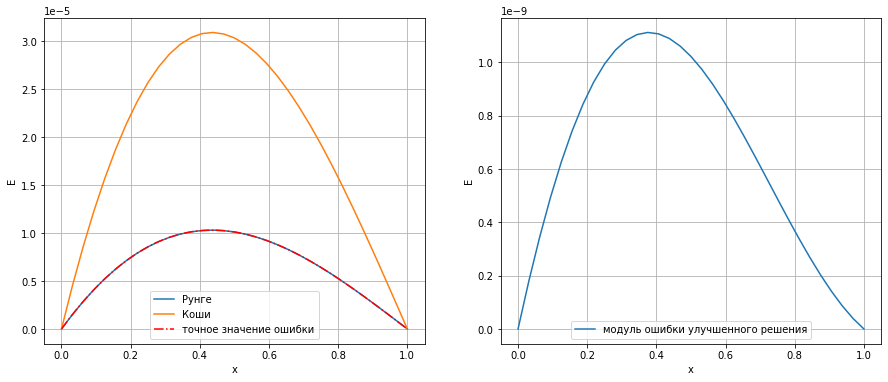

In [4]:
u0 = 1
ul = 0
l = 1
N1 = 2**6
h1 = 1 / N1
h2 = 2*h1
N2 = 2**5

q = lambda x: x**2
f = lambda x: (np.pi**2 / 4 + x**2) * np.cos((np.pi / 2) * x)

x1 = np.linspace(0, l, N1 + 1)
x2 = np.linspace(0, l, N2 + 1)

y1 = heat_trans(q, f, u0, ul, l, N1)
y2 = heat_trans(q, f, u0, ul, l, N2)

u1_exact = np.cos(np.pi * x1 / 2)
E1_exact = np.abs(y1 - u1_exact)

E_cauchy = np.abs(y2 - y1[::2])
E_sim = np.abs(y2 - y1[::2]) / (2**2 - 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax1, ax2 = axes
ax1.set(xlabel = "x", ylabel = "E")
ax1.plot(x2, E_sim, label = "Рунге")
ax1.plot(x2, E_cauchy, label = "Коши")
ax1.plot(x1, E1_exact, label = "точное значение ошибки", color='red', linestyle='dashdot')
ax1.legend()
ax1.grid(True)
ax1.legend(loc='best')

ax2.set(xlabel = "x", ylabel = "E")
ax2.plot(x2, np.abs(E1_exact[::2] - E_sim), label="модуль ошибки улучшенного решения")
ax2.grid(True)
ax2.legend(loc='best')

**Какой порядок точности по $h$ имеет улучшенное решение (Объясните аналитически)?
Можно ли как то получить улучшенное решение в оставшихся узлах сетки $1$ с той же точностью?**


Порядок точности по h равен 3.
Нужно уменьшить шаг в два раза и осуществить ту же программу.

# Динамическое уравнение теплопроводности

Начально-краевая задача для уравнения теплопроводности с постоянным коэффициентом в общем виде можно записать следующим образом:
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \alpha \dfrac{\partial^2 u}{\partial x^2} - q(x,t)u+f(x, t), \; t > 0, \; x \in (0, l_x), \\
\left. u \right|_{t=0} = u_0(x), \\
\left. u \right|_{x=0} = \mu_1(t), \\
\left. u \right|_{x=l_x} = \mu_2(t),
\end{array}$$
где $u(x, t)$ - функция температуры, $\alpha = const$ - коэффициент теплопроводности, $f(x, t)$ - функция источника, $q(x,t)$ - к-т теплоотдачи. 

## Явная схема

Запишем разностное уравнение явной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k} - 2 y_i^{k} + y_{i-1}^{k}}{h^2} - q_i^k y_i^k+ f_i^k,$$
где $\tau$ и $h$ - шаги по времени и пространству, $y_i^k$ - значение приближённого решения в точке $(i, k)$ сетки, $f_i^k$ - значение функции источника в той же точке сетки. 

Аппроксимируем начальное и граничные условия:
$$
\begin{array}{l}
y_i^0 = u_0(x_i), \; \forall i = \overline{0, N},\\
y_0^k = \mu_1(t_k), \\
y_N^k = \mu_2(t_k), \; \forall k > 0.
\end{array}$$

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Обратите внимание, что если парметры $q,f$ выходят на некоторую асимптотику по времени, то
$$\exists \lim\limits_{t \rightarrow \infty} u(x, t) = u_\infty (x).$$
поэтому расчёт в какой-то момент следует остановить (считать до установления).

Во время проведения расчетов помните о том, что явная схема *условно* устойчива.

    Это задание не сильно отличается от ранних дз на схемы Эйлера...

In [5]:
def heat_expl(init, bound1, bound2, alpha, lx, q, f, h=1e-2, tau=1e-4, tol=1e-5):
    """ Solve the heat equation `u_t = a*u_xx` for x in (0; lx) with an explicit scheme.
    
    Parameters
    ----------
    init : callable
       Initial condition - function of x
    bound1 : callable
       Boundary condition for x = 0 - function of t
    bound1 : callable
       Boundary condition for x = lx - function of t
    alpha : float
       Thermal diffusivity   
    q: callable
        heat emission coef - function of (x,t)
    f: callable
        heat source - function of (x,t)
    h : float
       Spatial step
    tau : float
       Time step
    tol : float, optional
       Target tolerance.
       Stop iterations when the 2-norm of the difference between 
       solution on this time step and the next is less the tol.
       
    Returns
    -------
    t_end : float
       End time of calculation
    u_end : ndarray, shape (N,)
       Limit u_∞(x) (See above)
    """   
    
    N = int(lx / h)
    k = 0
    y_1 = np.array([init(i * h) for i in range(N + 1)])
    y_2 = np.zeros(N + 1)
    
    while True:
        for i in range(1, N):
            y_2[i] = tau * (alpha * (y_1[i + 1] - 2 * y_1[i] + y_1[i - 1]) / h**2 
                             - q(i * h, k*tau) * y_1[i] + f(i * h, k*tau)) + y_1[i]
        y_2[0] = bound1(k*tau)
        y_2[-1] = bound2(k*tau)
        if np.linalg.norm(y_2 - y_1) < tol:
            t_end = (k+1)*tau
            u_end = y_2
            break
        k += 1
        y_1 = np.copy(y_2)
    return t_end, u_end

Протестируйте Вашу функцию.

In [6]:
from numpy.testing import assert_allclose


t_0, u_0 = heat_expl(init=lambda x: 0., bound1=lambda t: 1., bound2=lambda t: 1., 
                     alpha=1, lx=1, h=0.1, tau=0.005, q=lambda x,t:0, f=lambda x,t:0, tol=1e-3)
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_expl(init=lambda x: x**2, bound1=lambda t: 0., bound2=lambda t: 1., 
                     alpha=1, lx=1, h=0.01, tau=1e-5, q=lambda x,t:-np.pi**2/4, f=lambda x,t: 0, tol=1e-7)


x = np.linspace(0, 1, 100+1, endpoint=True)
assert_allclose(u_1, np.sin(np.pi/2*x), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче: 
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \dfrac{\partial^2 u}{\partial x^2} +1, \; t > 0, \; x \in (0, 1), \\
\left. u \right|_{t=0} = 0, 
\left. u \right|_{x=0} = 0, 
\left. u \right|_{x=1} = 0,\\
u(t\to+\infty)= \frac{x(1-x)}{2}
\end{array}$$


Для этого выберите некоторый момент времени $t_c \in (0, 0.2)$.

1. Сделайте несколько расчётов для разных значений пространственного шага (например, $h_0, \; 2 h_0, \; 4 h_0 \; 8h_0..$). 
Оцените погрешности "по Коши" $\epsilon_h(t_c) = max_{x}(|u_h(t_c) - u_{2h}(t_c)|)$. Постройте график $\epsilon_h(h)$. Определите порядок схемы.
2. Проделате аналогичную процедуру, варьируя шаг по времени $\tau_0, 2\tau_0 ..$.
3. Обратите внимание, что имеющуюся функцию `heat_expl` надо немного модифицировать. Помните про условную стабильность!
3. Найдите отношения этих ошибок. Сопоставьте полученные величины с порядком аппроксимации схемы по данной переменной. 

[ 2.13192253  3.69281109  7.31730119 16.21608957 26.45212311]


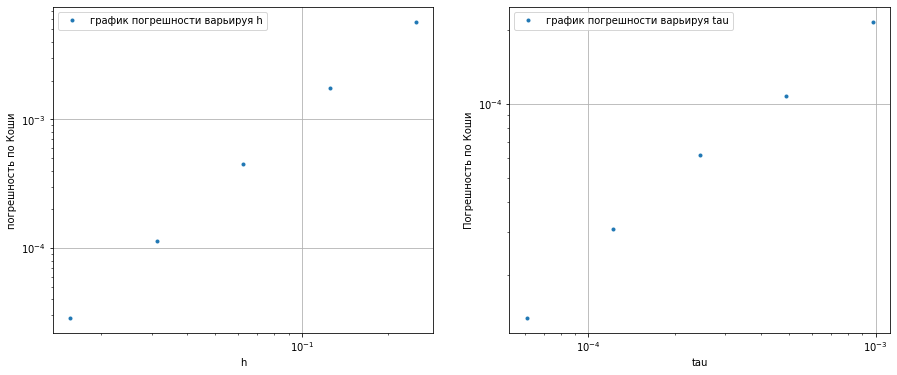

In [16]:
def heat_expl_modified (t_c, init = lambda x: 0., bound1 = lambda t: 0., q=lambda x, t: 0, f=lambda x, t: 1,
                bound2 = lambda t: 0., alpha = 1, 
                lx = 1, h = 1e-2, tau = 1e-4):

    N = int(lx / h)
    k = 0
    y_1 = np.array([init(i * h) for i in range(N + 1)])
    y_2 = np.zeros(N + 1)
    
    while True and (k + 1) * tau <= t_c:
        for i in range(1, N):
            y_2[i] = tau * (alpha * (y_1[i + 1] - 2 * y_1[i] + y_1[i - 1]) / h**2 
                             - q(i * h, k * tau) * y_1[i] + f(i * h, k * tau)) + y_1[i]
        y_2[0] = bound1(k * tau)
        y_2[-1] = bound2(k * tau)
        t_end = (k + 1) * tau
        u_end = y_2
        k += 1
        y_1 = np.copy(y_2)
    return u_end

t_c = 0.1
h_list = np.array([1 / 2**6, 1 / 2**5, 1 / 2**4, 1 / 2**3, 1 / 2**2, 1/2]) # 6 разных вариантов h
tau = 1 / 2**15
e1 = []
for i in range(len(h_list) - 1):
    e1.append(max(np.abs(heat_expl_modified(t_c = t_c, h = h_list[i+1], tau = tau) - (heat_expl_modified(t_c = t_c, h = h_list[i], tau = tau))[::2])))

t_c = 0.1
h = 1 / 2**2
tau_list = np.array([1 / 2**14, 1 / 2**13, 1 / 2**12, 1 / 2**11, 1 / 2**10, 1 / 2**9]) # 6 разных вариантов tau
e2 = []
for i in range(len(tau_list) - 1):
    e2.append(np.amax(abs(heat_expl_modified(t_c = t_c, h = h, tau = tau_list[i+1]) - (heat_expl_modified(t_c = t_c, h = h, tau = tau_list[i])))))


fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax1, ax2 = axes
ax1.plot(h_list[:-1], e1, '.', label = 'график погрешности варьируя h')
ax1.set(xlabel = "h", ylabel = "погрешность по Коши")
ax1.grid(True)
ax1.legend(loc='best')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.plot(tau_list[:-1], e2, '.', label = 'график погрешности варьируя tau')
ax2.set(xlabel = "tau", ylabel = "Погрешность по Коши")
ax2.grid(True)
ax2.legend(loc='best')

print(np.array(e1) / np.array(e2))
plt.yscale('log')
plt.xscale('log')

Порядок аппроксимации для шага временного $\tau$ линейный $O(\tau)$, а для пространственного шага $h$ $O(h^2)$.
В общем $O(h^2, \tau)$.

## Неявная схема 

Запишем разностное уравнение неявной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k+1} - 2 y_i^{k+1} + y_{i-1}^{k+1}}{h^2} - q_i^{k+1}y_i^{k+1}+ f_i^{k+1}.$$

Аппроксимировать начальное и граничные условия будем так же, как в случае явной схемы.

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности.

Для решения системы линейных уравнений можно использовать встроенные функции `scipy`...

    Полезно вспонить код из 1 задания...

In [8]:
def heat_impl(init, bound1, bound2, alpha, lx, q, f, h=1e-2, tau=1e-4, tol=1e-5):
    """ Solve the heat equation `u_t = a*u_xx` for x in (0; lx) with  implicit scheme.
    
    Parameters
    ----------
    init : callable
       Initial condition - function of x
    bound1 : callable
       Boundary condition for x = 0 - function of t
    bound1 : callable
       Boundary condition for x = lx - function of t
    alpha : float
       Thermal diffusivity   
    q: callable
        heat emission coef - function of (x,t)
    f: callable
        heat source - function of (x,t)
    h : float
       Spatial step
    tau : float
       Time step
    tol : float, optional
       Target tolerance.
       Stop iterations when the 2-norm of the difference between 
       solution on this time step and the next is less the tol.
       
    Returns
    -------
    t_end : float
       End time of calculation
    u_end : ndarray, shape (N,)
       Limit u_∞(x) (See above)
    """
    
    N = int(lx / h)
    y_2 =  np.array([init(i * h) for i in range(N + 1)])
    y_1 = np.ones(N+1)*10e3
    t = 0
    while y_2 is None or np.linalg.norm(y_2 - y_1) >= tol:
        y_1 = np.copy(y_2)
        t += tau
        D1 = np.ones(N - 1) * ( -alpha / h ** 2)
        D1[0] = 0
        D3 = np.ones(N - 1) * ( -alpha / h ** 2)
        D3[-1] = 0
        D2 = []
        F = []

        for i in range(N - 1):
            D2.append(q((i + 1)*h,t) + 1/tau + 2*alpha/h**2)
            F.append(f((i + 1)*h,t)+y_2[i + 1]/tau)
        F[0] -= ( - alpha / h ** 2) * bound1(t)
        F[-1] -= ( - alpha / h ** 2) * bound2(t)

        matrix = np.array([D1, D2, D3])
        y_2 = np.array([bound1(t), *solve_banded((1, 1), matrix, F), bound2(t)])
    t_end = t
    u_end = y_2
         
    return t_end, u_end

Протестируйте Вашу функцию.

In [9]:
from numpy.testing import assert_allclose


t_0,u_0 = heat_impl(init=lambda x: 0., bound1=lambda t: 1., bound2=lambda t: 1., 
                     alpha=1, lx=1, h=0.1, tau=0.005, q=lambda x,t:0.*x, f=lambda x,t:0.*x, tol=1e-3)
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_impl(init=lambda x: x**2, bound1=lambda t: 0., bound2=lambda t: 1., 
                     alpha=1, lx=1, h=0.01, tau=1e-5, q=lambda x,t:-np.pi**2/4 + 0.*x, f=lambda x,t: 0.*x, tol=1e-7)


x = np.linspace(0, 1, 100+1, endpoint=True)
assert_allclose(u_1, np.sin(np.pi/2*x), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. (см. выше)

[0.25586753 0.50951343 1.00175721 1.87944414 3.05681044]


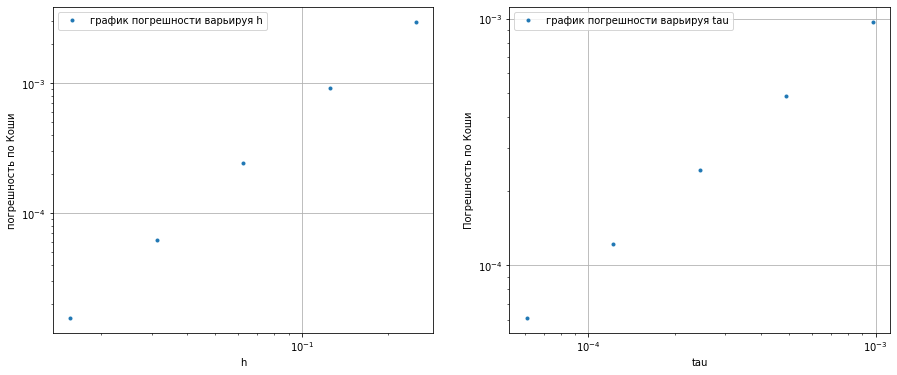

In [18]:
def heat_impl_modified(t_c, init = lambda x: 0., bound1 = lambda t: 0., q=lambda x, t: 0, f=lambda x, t: 1,
                bound2 = lambda t: 0., alpha = 1, 
                lx = 1, h = 1e-2, tau = 1e-4):

    N = int(lx / h)
    y_2 = np.array([init(i * h) for i in range(N + 1)])
    t = 0
    while t < t_c:
        t += tau
        D1 = np.ones(N - 1) * ( -alpha / h ** 2)
        D1[0] = 0
        D3 = np.ones(N - 1) * ( -alpha / h ** 2)
        D3[-1] = 0
        D2 = []
        F = []

        for i in range(N - 1):
            D2.append(q((i + 1)*h,t) + 1/tau + 2*alpha/h**2)
            F.append(f((i + 1)*h,t)+y_2[i+1]/tau)
        F[0] -= ( - alpha / h ** 2) * bound1(t)
        F[-1] -= ( - alpha / h ** 2) * bound2(t)

        matrix = np.array([D1, D2, D3])
        y = np.array([bound1(t), *solve_banded((1, 1), matrix, F), bound2(t)])
    t_end = t
    u_end = y
         
    return u_end

t_c = 0.1
h_list = np.array([1 / 2**6, 1 / 2**5, 1 / 2**4, 1 / 2**3, 1 / 2**2, 1/2]) # 6 разных вариантов h
e3 = []
tau = 1 / 2**4

for i in range(len(h_list) - 1):
    e3.append(np.amax(abs(heat_impl_modified(t_c = t_c, h = h_list[i+1], tau = tau) - (heat_impl_modified(t_c = t_c, h = h_list[i], tau = tau))[::2])))

t_c = 0.1
h = 1 / 2**2
tau_list = np.array([1 / 2**14, 1 / 2**13, 1 / 2**12, 1 / 2**11, 1 / 2**10, 1 / 2**9]) # 6 разных вариантов tau
e4 = []
for i in range(len(tau_list) - 1):
    e4.append(np.amax(abs(heat_impl_modified(t_c = t_c, h = h, tau = tau_list[i+1]) - (heat_impl_modified(t_c = t_c, h = h, tau = tau_list[i])))))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax1, ax2 = axes
ax1.plot(h_list[:-1], e3, '.', label = 'график погрешности варьируя h')
ax1.set(xlabel = "h", ylabel = "погрешность по Коши")
ax1.grid(True)
ax1.legend(loc='best')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.plot(tau_list[:-1], e4, '.', label = 'график погрешности варьируя tau')
ax2.set(xlabel = "tau", ylabel = "Погрешность по Коши")
ax2.grid(True)
ax2.legend(loc='best')
plt.yscale('log')
plt.xscale('log')

print(np.array(e3) / np.array(e4))

Как мы видим, для неявной схемы также порядок аппроксимации для шага временного $\tau$ линейный $O(\tau)$, а для пространственного шага $h$ $O(h^2)$. В общем $O(h^2, \tau)$.